In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper")
y_labels = ["love", "haha", "wow", "angry", "sad"]
actual_reactions_list = ["fb_love", "fb_haha", "fb_wow", "fb_angry", "fb_sad"]

reaction_class = {
    "fb_love": 0, 
    "fb_haha": 1,
    "fb_wow": 2,
    "fb_angry": 3,
    "fb_sad": 4
}

# Raw dataset
import json
db_json_filename = "data/facebook_pages_data.json"
dataset = pd.read_json(db_json_filename)

In [2]:
from sklearn.externals import joblib
clf = joblib.load('output/final_model.pkl')
clf_prob = joblib.load('output/final_model_prob.pkl')

## Preprocessing Function

This function certainly has to be optimized for production.

In [3]:
def preprocess_text(text):
    import nltk
    import json
    import re
    from nltk.tokenize import RegexpTokenizer
    from unidecode import unidecode
    
    def tokenize(text):
        pattern = r"""(?x)                    # set flag to allow verbose regexps
              (?:[a-zA-Z]\.)+                 # abbreviations, e.g. U.S.A.
              |[a-zA-Z]+(?:[-'*][a-zA-Z]+)*   # words w/ optional internal hyphens/apostrophe
            """
        text = text.lower()
        # Tokenize words without punctuation
        tokenizer = nltk.RegexpTokenizer(pattern)
        return tokenizer.tokenize(text)
    
    def special(text):
        text = text.split("|")[0]
        text = re.sub("[\(].*?[\)]", "", text)
        return text
    
    bad_words_path = "resources/bad_words.json"  
    with open(bad_words_path, "r") as file:
        bad_words = json.loads(file.read())

    def censor(word):
        for bad_word in bad_words.keys():
            if bad_word in word:
                #word = word.replace(bad_word, bad_words[bad_word], 1)
                word = bad_words[bad_word]
        return word
    
    def tokenize_bad_words(tokens):
        tokens = [censor(word) for word in tokens]    
        return tokens
    
    contractions_path = "resources/contractions.json"  
    with open(contractions_path, "r") as file:
        contractions = json.loads(file.read())

    def separate_contraction(word):
        for contraction in contractions.keys():
            if contraction in word:
                #word = word.replace(bad_word, bad_words[bad_word], 1)
                word = contractions[contraction]
        return word.split()

    def tokenize_contractions(tokens):
        output = []
        for word in tokens:
            output.extend(separate_contraction(word))
        return output
    
    stopwords = nltk.corpus.stopwords.words('english')
    special_stopwords_path = "resources/special_stopwords.txt"  
    with open(special_stopwords_path, "r") as file:
        special_stopwords = file.read().splitlines()

    from nltk.stem import WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()

    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer("english")

    def tokenize_stem_stopwords(tokens):
        tokens = [word for word in tokens if (word not in stopwords and word not in special_stopwords)]
        short_tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
        short_tokens = [stemmer.stem(t) for t in short_tokens]
        return short_tokens
    
    return " ".join(tokenize_stem_stopwords(
                        tokenize_contractions(
                            tokenize_bad_words(
                                tokenize(unidecode(special(text)))))))

In [4]:
def preprocess(array):
    return [preprocess_text(text) for text in array]

## Trying with some headlines

In [5]:
def make_yprob(y_probabilities):
    array_yprobs = []
    for probabilities in y_probabilities:
        string_probs = ""
        i = 1
        for y_prob, y_label in sorted(zip(probabilities, y_labels), reverse=True):
            if isinstance(y_prob, int) or isinstance(y_prob, np.int64):
                string_probs += "{}:{}".format(y_label, y_prob)
            else:
                string_probs += "{}:{:.3}".format(y_label, y_prob)
            if i != 5:
                string_probs += ", "
            i += 1
        array_yprobs.append(string_probs)
    return array_yprobs

def id_to_label(y_ids):
    return [y_labels[y_id] for y_id in y_ids]

In [38]:
headlines = ["Justin Bieber is dead",
             "Isis has nothing to do with islam",
             "killed",
             "justin",
             "top 10 movies",
             "This Teen Applied A Facemask For The First Time And Instantly Regretted It",
             "Millions Of Honey Bees Killed Accidentally By Zika Mosquito Spray",
             "World's Largest Primate Now Considered 'Critically Endangered'"]

headlines_prep = preprocess(headlines)
y_pred = clf.predict(headlines_prep)
y_prob = clf_prob.predict_proba(headlines_prep)

In [39]:
pd.set_option('display.max_colwidth', 200)

d = {"Headline": headlines,
     "$y_{pred}$": id_to_label(y_pred),
     "$y_{prob}$": make_yprob(y_prob)
     }

table_test = pd.DataFrame(data=d, columns=["Headline", "$y_{pred}$", "$y_{prob}$"])

table_file = open("notebook_figures/{}.tex".format("table_test"), "w")
table_file.write(table_test.to_latex(index=False))
table_file.close()
table_test

,Headline,$y_{pred}$,$y_{prob}$
0,Justin Bieber is dead,haha,"haha:0.61, sad:0.375, angry:0.0141, wow:0.0, love:0.0"
1,Isis has nothing to do with islam,angry,"angry:0.757, haha:0.243, wow:0.0, sad:0.0, love:0.0"
2,killed,sad,"sad:0.867, angry:0.133, wow:0.0, love:0.0, haha:0.0"
3,justin,haha,"haha:0.625, love:0.262, angry:0.113, wow:0.0, sad:0.0"
4,top 10 movies,love,"love:0.956, haha:0.0246, angry:0.0198, wow:0.0, sad:0.0"
5,This Teen Applied A Facemask For The First Time And Instantly Regretted It,haha,"haha:0.701, love:0.299, wow:0.0, sad:0.0, angry:0.0"
6,Millions Of Honey Bees Killed Accidentally By Zika Mosquito Spray,sad,"sad:0.453, haha:0.431, wow:0.116, love:0.0, angry:0.0"
7,World's Largest Primate Now Considered 'Critically Endangered',love,"sad:0.645, wow:0.17, love:0.152, haha:0.032, angry:0.0"


## Test data

Testing with unseen data from August 29th to September 4th.

In [8]:
def slice_dataset(df, start_time, end_time):
    return df[(df['time_created'] >= start_time) & (df['time_created'] <= end_time)]

dataset_test = slice_dataset(dataset, "2016-08-29", "2016-09-04")

Adding the highest reaction column

In [9]:
def highest_reaction(dataframe_row):
    reactions_row = dataframe_row[actual_reactions_list]
    reactions_row.sort_values(ascending=False, inplace=True)
    total_reactions = reactions_row.sum()
    
    max_reaction = reactions_row.index[0]
    max_votes = reactions_row.max()
    reaction_id = reaction_class[max_reaction]
    if total_reactions > 100:
        return reaction_id
    return None

function = highest_reaction
dataset_test.loc[:,function.__name__] = dataset_test.apply(lambda x: function(x), axis=1)

/Users/rgap/.virtualenvs/vfanpage/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/rgap/.virtualenvs/vfanpage/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
reactions_list = ["fb_like"] + actual_reactions_list

def fb_total_reactions(dataframe_row):
    return sum(dataframe_row[r] for r in reactions_list)

function = fb_total_reactions
dataset_test.loc[:,function.__name__] = dataset_test.apply(lambda x: function(x), axis=1)

/Users/rgap/.virtualenvs/vfanpage/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/rgap/.virtualenvs/vfanpage/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
def remove_no_reaction(df):
    tmp = df[(df['highest_reaction'].notnull())]
    return tmp[tmp['fb_total_reactions'] >= 200]
    
dataset_test = remove_no_reaction(dataset_test)
dataset_test.loc[:,"highest_reaction"] = dataset_test.loc[:,"highest_reaction"].astype(int)

**Taking a random sample**

In [12]:
random_sample = dataset_test.sample(8, random_state=123)
headlines = random_sample["name"]

In [13]:
headlines_prep = preprocess(headlines)
y_true = random_sample[actual_reactions_list].as_matrix()
y_pred = clf.predict(headlines_prep)
y_prob = clf_prob.predict_proba(headlines_prep)

In [14]:
d = {"Headline": headlines,
     "$y_{true}$": make_yprob(y_true),
     "$y_{pred}$": id_to_label(y_pred),
     "$y_{prob}$": make_yprob(y_prob)
     }

table_sample = pd.DataFrame(data=d, columns=["Headline", "$y_{pred}$", "$y_{prob}$", "$y_{true}$"])
table_file = open("notebook_figures/{}.tex".format("table_sample"), "w")
table_file.write(table_sample.to_latex(index=False))
table_file.close()
table_sample

,Headline,$y_{pred}$,$y_{prob}$,$y_{true}$
32699,Huma Abedin And Anthony Weiner Are Separating,haha,"haha:0.519, sad:0.24, love:0.195, angry:0.0461, wow:0.0","haha:86, sad:77, love:38, wow:34, angry:4"
12265,Apartment complex warns residents about clown trying to lure kids into woods,sad,"sad:0.567, haha:0.19, love:0.171, wow:0.0712, angry:0.0","wow:1571, angry:770, sad:66, haha:58, love:28"
5437,California Lawmakers Pass Bill Requiring Prison Sentence After Stanford Sex Assault Case,angry,"angry:0.771, love:0.229, wow:0.0, sad:0.0, haha:0.0","love:1958, angry:751, wow:48, sad:42, haha:6"
56041,Triumphant Tarantula Survives Being Eaten By Toad,sad,"sad:0.357, haha:0.303, love:0.227, wow:0.114, angry:0.0","wow:1388, haha:382, love:156, sad:15, angry:5"
12170,Scientists discover oldest fossils on Earth,wow,"wow:0.996, sad:0.00439, love:0.0, haha:0.0, angry:0.0","wow:189, love:60, haha:15, sad:2, angry:2"
48,Wilderness Expert Finds A Giant Black Slug Which Is Way Bigger And Cooler Than You Thought | 9GAG.tv,haha,"haha:0.527, wow:0.445, angry:0.0285, sad:0.0, love:0.0","wow:837, love:169, haha:144, sad:14, angry:1"
12268,Georgia teacher dreams up dice game about slavery. It didn't go well.,love,"love:0.855, haha:0.142, wow:0.00315, sad:0.0, angry:0.0","angry:107, wow:96, haha:42, love:9, sad:7"
32579,Latino Trump Supporter Warns Of 'Taco Trucks On Every Corner',haha,"haha:0.486, love:0.238, angry:0.198, sad:0.0773, wow:0.0","haha:1524, love:231, wow:52, angry:30, sad:4"


## Confusion Matrix

To see what kind of headlines are being missclassified.

In [15]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=10) 
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, fontsize=12)
    plt.yticks(tick_marks, labels, fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    
    plt.savefig('notebook_figures/{}.pdf'.format("conf"),
                bbox_inches='tight')
    plt.show()

In [16]:
y_true = dataset_test["highest_reaction"]
y_pred = clf.predict(preprocess(dataset_test["name"]))

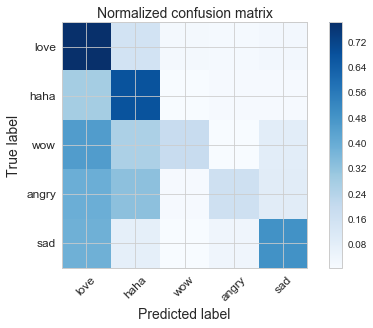

In [17]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_confusion_matrix(cm_normalized, labels=y_labels, title='Normalized confusion matrix')